# https://github.com/ianlucas1/aai-iot-linear-regression.git

# Assignment 3.1

**Name:**  Ian Lucas

**Course:** AAI-530

**Date:**  01/23/25

**Note**: For this assignment, I used OpenAI’s ChatGPT-4 (2025) and GPT-4 Turbo (o1) (2025) for assistance in generating code snippets (including logic formulation, output formatting, syntax correction, and debugging).

# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.


In [1]:
#use this cell to import additional libraries or define helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from IPython.display import display
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [2]:
# Load the CSV file
file_path = "household_power_clean.csv"  # Adjust the path if necessary
df = pd.read_csv(file_path)

display(df.head(3), df.tail(3), df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
 11  gap_monthly            float64
 12  grp_monthly            float64
 13  v_monthly              float64
 14  gi_monthly             float64
dtypes: float64(11), int64(1), object(3)
memory usage: 234.5+ MB


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
2049277,2075256,2010-11-26,21:00:00,0.93800,0.00000,239.82000,3.80000,0.00000,0.00000,0.00000,2010-11-26 21:00:00,0.96927,0.03480,238.98800,4.06667
2049278,2075257,2010-11-26,21:01:00,0.93400,0.00000,239.70000,3.80000,0.00000,0.00000,0.00000,2010-11-26 21:01:00,0.96767,0.03480,239.00033,4.05333
2049279,2075258,2010-11-26,21:02:00,0.93200,0.00000,239.55000,3.80000,0.00000,0.00000,0.00000,2010-11-26 21:02:00,0.96600,0.03480,238.97867,4.04000


None

In [31]:
# Converting of 'Datetime' to Unix/Epoch time
df['unix'] = pd.to_datetime(df['Datetime']).astype('int64') // 10**9


In [4]:
# Checking the first few rows of the new column to verify the conversion
print(df[['Datetime', 'unix']].head())


              Datetime        unix
0  2006-12-16 17:24:00  1166289840
1  2006-12-16 17:25:00  1166289900
2  2006-12-16 17:26:00  1166289960
3  2006-12-16 17:27:00  1166290020
4  2006-12-16 17:28:00  1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph (Prediction Horizon) defines how far into the future the model predicts. For example, if ph = 10, the model forecasts 10 time units (e.g., seconds or minutes) ahead.

mu (Forgetting Factor) determines how much weight is given to older data points. A value near 1 prioritizes recent data while still considering the past, whereas lower values discount older data more significantly.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
# Extract time (unix) and target variable (Global Active Power) from the DataFrame
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Set prediction horizon to 5 minutes (each timestep represents 1 minute)
ph = 5  # in minutes
ph_index = ph  # 1 timestep = 1 minute

# Forgetting factor
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


In [6]:
mu = 0.9
k = 4999
weight = mu ** k
print(weight)


1.8126113170475857e-229


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: When mu = 0.9, the weight of the first data point on the last (5000th) prediction is approximately 0.9^4999, which is effectively zero. This demonstrates that the forgetting factor strongly reduces the influence of older data.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [7]:
# Flattened arrays to resolve NumPy deprecation warnings

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s + 1):  # start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ys_tmp = ys.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ns = len(ys_tmp)
    
    # Create weights adjusted based on their timestep away from the prediction
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Downweight according to the timestep
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
    
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp.reshape(-1, 1), ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]  # slope of the regression line
    q_tmp = model_tmp.intercept_  # intercept of the regression line

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1, 0] + (ph_index * 60)  # Convert ph to seconds (since unix is in seconds)
    yp = m_tmp * tp + q_tmp  # Linear regression prediction
    
    # Ensure scalar values before assignment to the arrays
    tp_pred[i - 2] = float(tp)  # Explicit scalar conversion
    yp_pred[i - 2] = float(yp)  # Explicit scalar conversion


Now let's visualize the results from our model.

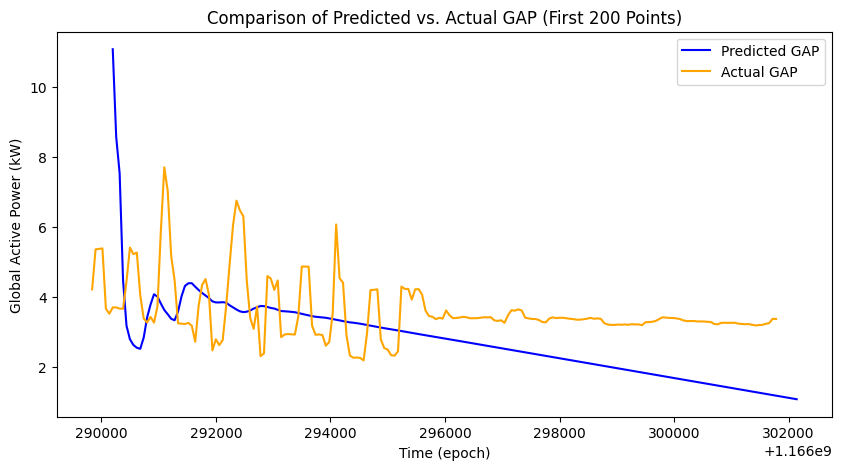

In [8]:
# Plot a comparison of predicted vs. actual GAP for a sample
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='orange')
ax.set_title('Comparison of Predicted vs. Actual GAP (First 200 Points)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

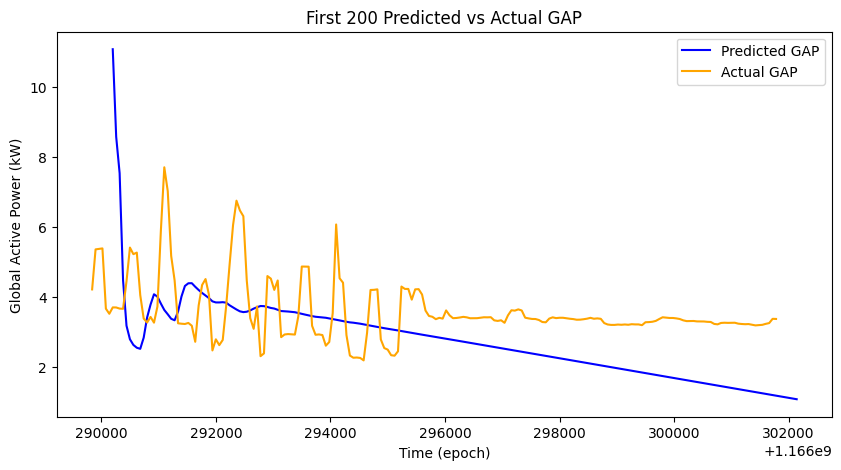

In [9]:
# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='orange')
ax.set_title('First 200 Predicted vs Actual GAP')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


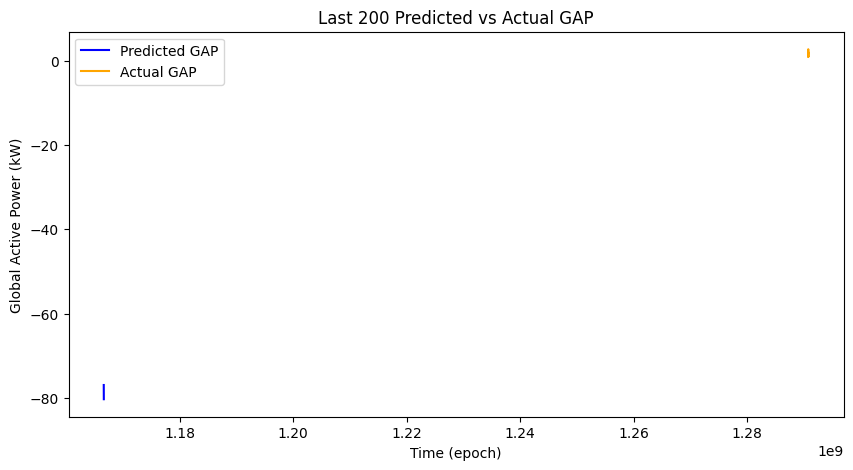

In [10]:
# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='orange')
ax.set_title('Last 200 Predicted vs Actual GAP')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


In [11]:
# Calculate MSE for predictions
mse_value = mse(ys.iloc[ph_index:5000 + ph_index - 1, 0], yp_pred)
print("MSE is:", mse_value)


MSE is: 2147.765993380549


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: 

- The first 200 data points plot shows that the predicted values do not follow the variability in the actual data. The predictions have a consistent downward slope, indicating the model is not be capturing the relationship effectively.

- The last 200 data points plot highlights the same issue, with predictions failing to align with the actual values.

- The model appears to struggle in capturing the variability of the Global Active Power data.

- Predictions are oversimplified, likely due to limited features and the forgetting factor not being effective enough.

- Early predictions slightly follow the trend but are not accurate.

- Late predictions deviate significantly, likely due to accumulating errors from the forgetting factor (mu).

- The MSE is 2147.77, indicating that the model's predictions are significantly different from the actual values, reinforcing that the current model is not a good one.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [12]:
# Set forgetting factor to 1
mu = 1

# Re-run the prediction loop
for i in range(2, n_s + 1):  # Start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ys_tmp = ys.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ns = len(ys_tmp)
    
    # Create uniform weights since mu = 1 (no forgetting)
    weights = np.ones(ns)
    
    # Perform linear regression on "available" data using uniform weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp.reshape(-1, 1), ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]  # Slope
    q_tmp = model_tmp.intercept_  # Intercept

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1, 0] + (ph_index * 60)  # Convert ph to seconds
    yp = m_tmp * tp + q_tmp  # Linear regression prediction
    
    # Assign scalar values to the arrays
    tp_pred[i - 2] = float(tp)
    yp_pred[i - 2] = float(yp)


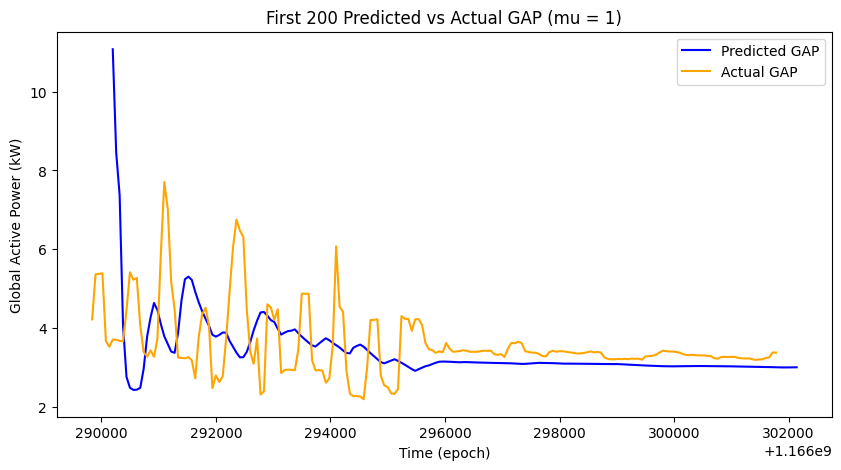

In [13]:
# Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='orange')
ax.set_title('First 200 Predicted vs Actual GAP (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


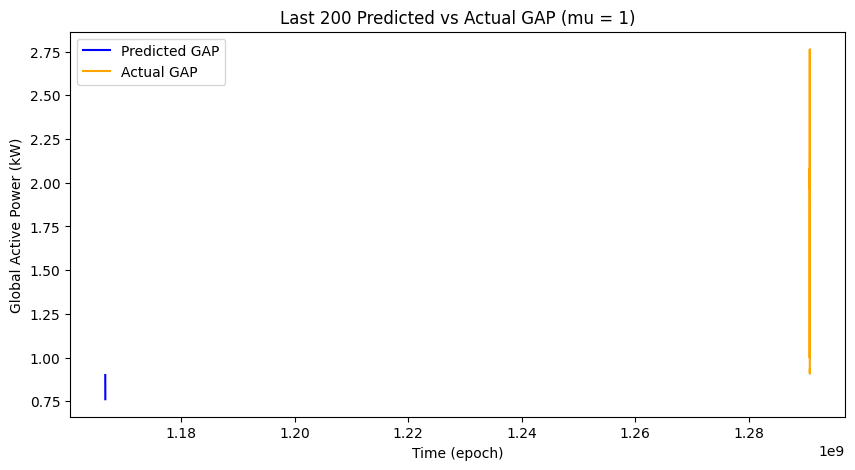

In [14]:
# Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='orange')
ax.set_title('Last 200 Predicted vs Actual GAP (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


In [15]:
# Calculate MSE for predictions for mu = 1
mse_value = mse(ys.iloc[ph_index:5000 + ph_index - 1, 0], yp_pred)
print("MSE is:", mse_value)


MSE is: 1.4433474819592909


In [16]:
# Set forgetting factor to 0.01
mu = 0.01

# Re-run the prediction loop
for i in range(2, n_s + 1):  # Start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ys_tmp = ys.iloc[0:i].values.flatten()  # Flatten to ensure 1D NumPy array
    ns = len(ys_tmp)
    
    # Create weights adjusted based on their timestep away from the prediction
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Downweight according to the timestep
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
    
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp.reshape(-1, 1), ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]  # Slope
    q_tmp = model_tmp.intercept_  # Intercept

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1, 0] + (ph_index * 60)  # Convert ph to seconds
    yp = m_tmp * tp + q_tmp  # Linear regression prediction
    
    # Assign scalar values to the arrays
    tp_pred[i - 2] = float(tp)
    yp_pred[i - 2] = float(yp)


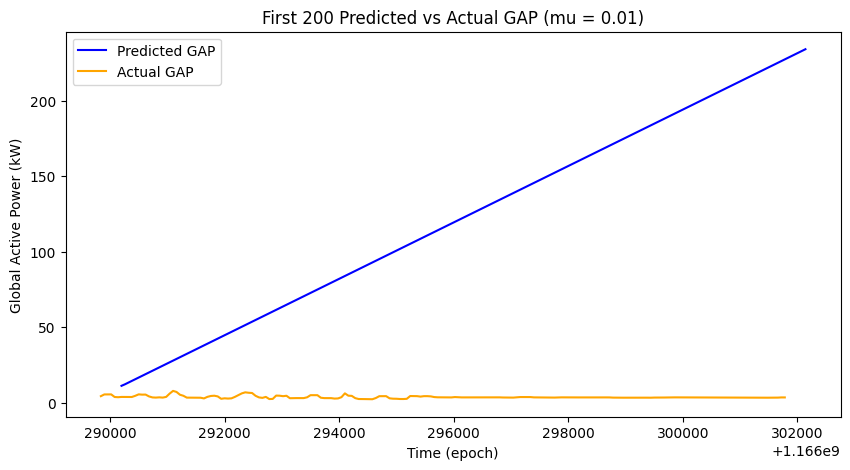

In [17]:
# Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual GAP', color='orange')
ax.set_title('First 200 Predicted vs Actual GAP (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


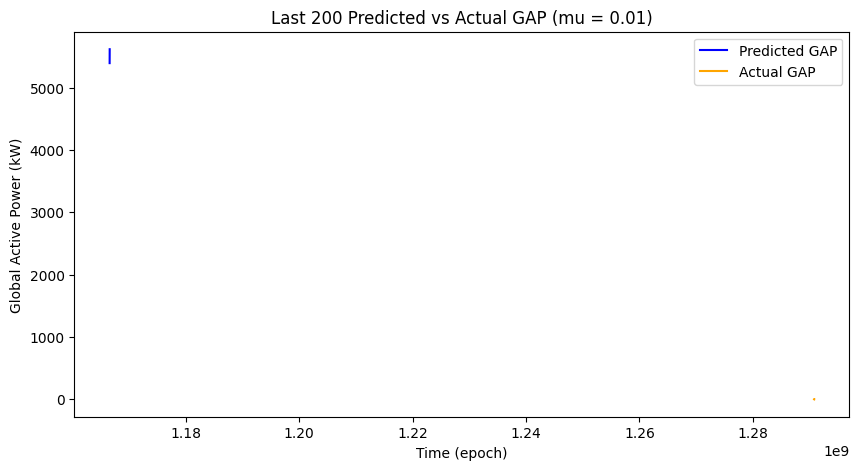

In [18]:
# Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual GAP', color='orange')
ax.set_title('Last 200 Predicted vs Actual GAP (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.show()


In [19]:
# Calculate MSE for predictions
mse_value = mse(ys.iloc[ph_index:5000 + ph_index - 1, 0], yp_pred)
print("MSE is:", mse_value)


MSE is: 10527735.463340823


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

- The predictions (blue line) now show a more stable trend and align better with the mean of the actual data, particularly for the first 200 points.

- The last 200 points still show significant deviation, indicating that the model doesn't capture the full variability of the data over time.

- The MSE is 1.44, which is a significant improvement over the μ = 0.9 case (MSE = 2147.77). This suggests that a forgetting factor of 𝜇 = 1  (i.e., no forgetting) results in a more stable and accurate model.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model's predictions deviate significantly from the actual data due to overemphasis on recent points. Early predictions grow unrealistically large, while late predictions diverge even more. The MSE is 10,527,735, much higher than for mu = 1 and mu = 0.9, indicating poor performance.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The mu = 1 model is the best. Its MSE (1.44) is the lowest, and predictions align better with the actual data compared to mu = 0.9 and mu = 0.01. This makes sense as mu = 1 gives equal weight to all data, avoiding overemphasis on recent or old data.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We can: 1) Add more features to improve explanatory power, 2) Normalize input features to reduce the impact of scaling differences, and 3) Try using a non-linear model (e.g., polynomial regression) to better capture variability.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [20]:
# Add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df['unix'],
    'voltage': df['Voltage']
})
ys = pd.DataFrame(df['Global_active_power'])

ph = 5  # 5 minutes
ph_index = ph  # 1 timestep = 1 minute
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

# Fit the linear regression model with a forgetting factor
from sklearn.linear_model import LinearRegression
model = LinearRegression()

for i in range(2, n_s + 1):  # Start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i].values  # Use the first i rows of ts
    ys_tmp = ys.iloc[0:i, 0].values  # Use the first i rows of ys
    
    # Compute weights using the forgetting factor
    weights = mu ** np.arange(len(ys_tmp))[::-1]

    # Fit the model with weighted data
    model.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Make a prediction for the next time step
    if i + ph_index - 1 < n_s:  # Ensure we don't exceed the dataset bounds
        ts_next = ts.iloc[i + ph_index - 1].values.reshape(1, -1)  # Next time step
        yp_pred[i - 2] = model.predict(ts_next).item()  # Extract scalar from array
        tp_pred[i - 2] = ts.iloc[i + ph_index - 1, 0]  # Store corresponding time


In [21]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

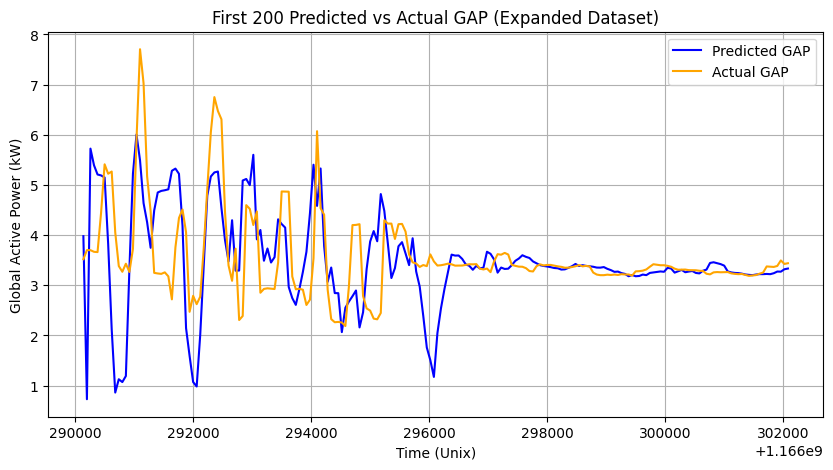

In [22]:
# Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 5))

# Adjust indices to align predictions and actual values
ax.plot(ts.iloc[ph_index:ph_index + 200, 0], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[ph_index:ph_index + 200, 0], ys.iloc[ph_index:ph_index + 200, 0], label='Actual GAP', color='orange')

ax.set_title('First 200 Predicted vs Actual GAP (Expanded Dataset)')
ax.set_xlabel('Time (Unix)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.grid(True)
plt.show()



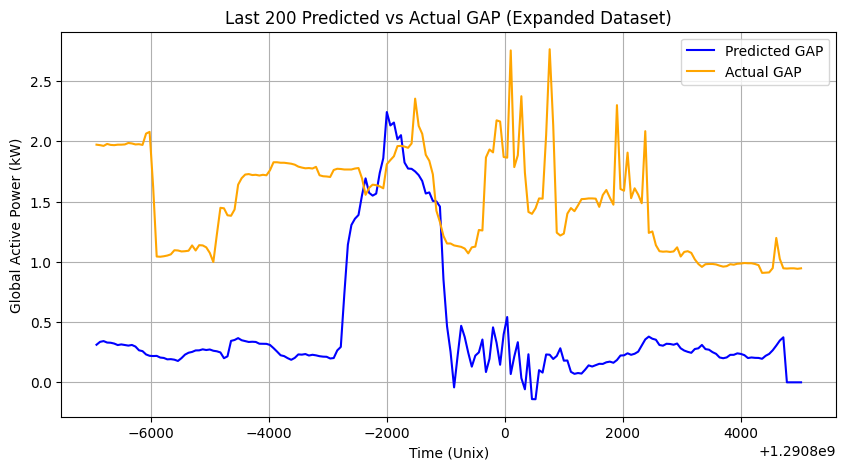

In [23]:
# Plot last 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 5))

# Adjust indices to align predictions and actual values
ax.plot(ts.iloc[-200 - ph_index:-ph_index, 0], yp_pred[-200:], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[-200 - ph_index:-ph_index, 0], ys.iloc[-200 - ph_index:-ph_index, 0], label='Actual GAP', color='orange')

ax.set_title('Last 200 Predicted vs Actual GAP (Expanded Dataset)')
ax.set_xlabel('Time (Unix)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.grid(True)
plt.show()


In [24]:
# Calculate MSE for predictions
mse_value = mse(ys.iloc[ph_index:ph_index + len(yp_pred), 0], yp_pred)
print("MSE for expanded dataset is:", mse_value)


MSE for expanded dataset is: 0.49051289542061843


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model had a MSE of 0.49, which is well below those of the earlier models and the predicted GAP more closely resembled the Actual GAP, even staying in the general vicinity in the last 200 observations (whereas in the earlier models, the final 200 observations of the predictions had no visual relation to the Actual GAP).

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I will add Global_intensity as a new feature in the model.  This variable measures the total current drawn, which is directly related to power consumption, but represents a different dimension from voltage with respect to total power.  Adding this feature should improve the model's realism and accuracy without introducing issues like multicollinearity (which I will test for below).  I will also normalize the features to ensure differences in scale do not affect the model's performance.

In [25]:
# re-run the prediction code here

# Add Global_intensity and normalize the features
scaler = StandardScaler()
features = ['unix', 'Voltage', 'Global_intensity']  
ts = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
ys = pd.DataFrame(df['Global_active_power'])

ph = 5  # 5 minutes
ph_index = ph  # 1 timestep = 1 minute
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

# Fit the linear regression model with a forgetting factor
model = LinearRegression()

for i in range(2, n_s + 1):  # Start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i].values  # Use the first i rows of ts
    ys_tmp = ys.iloc[0:i, 0].values  # Use the first i rows of ys
    
    # Compute weights using the forgetting factor
    weights = mu ** np.arange(len(ys_tmp))[::-1]

    # Fit the model with weighted data
    model.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Make a prediction for the next time step
    if i + ph_index - 1 < n_s:  # Ensure we don't exceed the dataset bounds
        ts_next = ts.iloc[i + ph_index - 1].values.reshape(1, -1)  # Next time step
        yp_pred[i - 2] = model.predict(ts_next).item()  # Extract scalar from array
        tp_pred[i - 2] = ts.iloc[i + ph_index - 1, 0]  # Store corresponding time


In [26]:
# Confirming multicollinearity is not an issue with added variable
corr_matrix = ts.corr()
print(corr_matrix)

X = ts.values
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("VIF for each feature:", vif)


                     unix  Voltage  Global_intensity
unix              1.00000  0.24937          -0.04581
Voltage           0.24937  1.00000          -0.41136
Global_intensity -0.04581 -0.41136           1.00000
VIF for each feature: [1.0707391891745013, 1.2861312069476452, 1.2086883585964026]


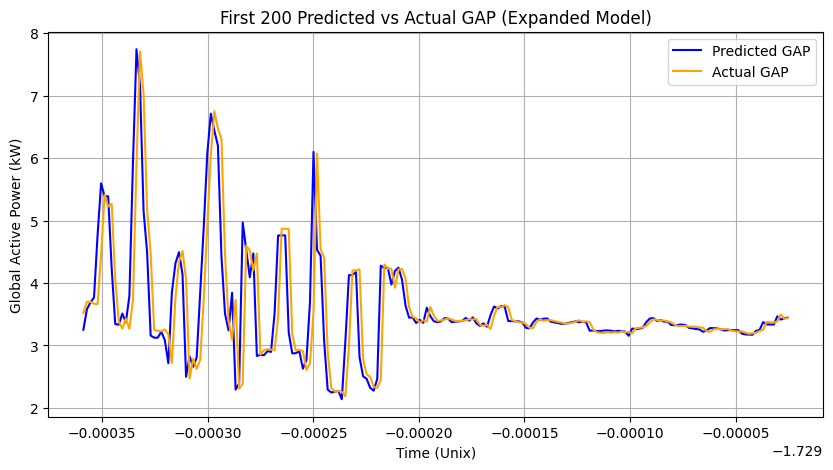

In [27]:
# Plot the first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ts.iloc[ph_index:ph_index + 200, 0], yp_pred[:200], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[ph_index:ph_index + 200, 0], ys.iloc[ph_index:ph_index + 200, 0], label='Actual GAP', color='orange')

ax.set_title('First 200 Predicted vs Actual GAP (Expanded Model)')
ax.set_xlabel('Time (Unix)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.grid(True)
plt.show()


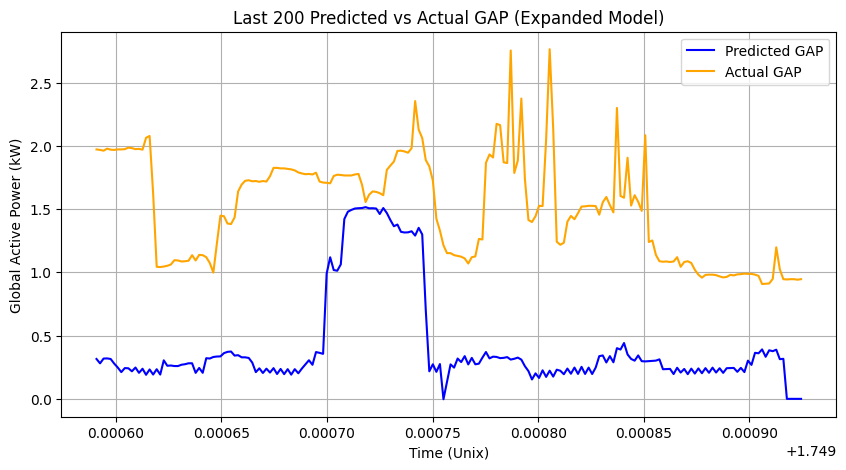

In [28]:
# Plot the last 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ts.iloc[-200 - ph_index:-ph_index, 0], yp_pred[-200:], label='Predicted GAP', color='blue')
ax.plot(ts.iloc[-200 - ph_index:-ph_index, 0], ys.iloc[-200 - ph_index:-ph_index, 0], label='Actual GAP', color='orange')

ax.set_title('Last 200 Predicted vs Actual GAP (Expanded Model)')
ax.set_xlabel('Time (Unix)')
ax.set_ylabel('Global Active Power (kW)')
ax.legend()
plt.grid(True)
plt.show()


In [29]:
# Calculate MSE of predictions for alternative model
actual_values = ys.iloc[ph_index:ph_index + len(yp_pred), 0].values
mse_value = mse(actual_values, yp_pred)
print("MSE for expanded model with Global_intensity:", mse_value)

MSE for expanded model with Global_intensity: 0.25088738802254623


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The alternative model with Global_intensity significantly improved the MSE, reducing it to 0.2508, showing that the feature adds meaningful predictive value.  To further improve the model, I would consider: 1) incorporating time-based features like hour of the day or day of the week, 2) adding interaction terms like Voltage × Global_intensity to capture non-linear relationships, or 3) increasing the prediction horizon to test the model's effectiveness over longer timeframes (which might be challenging, but valuable).  Regularization methods like Ridge or Lasso could help optimize the model if I were to add more features.

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.